# NHANES (National Health and Nutrition Examination Survey) Introductory Analysis

In this notebook, we will use the PIC-SURE API to pull participant-level data from NHANES into our Sagemaker notebook. We will perform an initial exploration and visualization of the data.

1. Package installation and environment set-up
2. Connecting to a PIC-SURE resource
3. Accessing and exploring the NHANES data dictionary
4. Building a query and retrieving data from NHANES
5. Explore and visualize the demographics and laboratory values of the NHANES dataset

To explore the NHANES dataset using the PIC-SURE User Interface, visit: https://pic-sure.aim-ahead-dev.host/

To learn more about the NHANES dataset, visit: https://www.cdc.gov/nchs/nhanes/about_nhanes.htm

## Package installation and environment set-up

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
%%capture

!{sys.executable} -m pip install --upgrade --force-reinstall git+https://github.com/hms-dbmi/pic-sure-python-client.git
!{sys.executable} -m pip install --upgrade --force-reinstall git+https://github.com/hms-dbmi/pic-sure-python-adapter-hpds.git
!{sys.executable} -m pip install --upgrade --force-reinstall git+https://github.com/hms-dbmi/pic-sure-biodatacatalyst-python-adapter-hpds.git

In [3]:
import PicSureClient
import PicSureBdcAdapter

## Connecting to a PIC-SURE resource

The following is required to get access to the PIC-SURE API:
* a network URL
* a user-specific security token saved as `token.txt`.

If you have not already retrieved your user-specific token, please visit the following documentation: https://pic-sure.gitbook.io/aim-ahead-pic-sure/data-analysis-using-the-pic-sure-api/pic-sure-user-access-token

In [4]:
token_file = "token.txt"

with open(token_file, "r") as f:
    my_token = f.read()
    

In [32]:
PICSURE_network_URL = "https://pic-sure.aim-ahead.host/picsure"
picsure_api = PicSureBdcAdapter.Adapter(PICSURE_network_URL, my_token)

+--------------------------------------+------------------------------------------------------+
|  Resource UUID                       |  Resource Name                                       |
+--------------------------------------+------------------------------------------------------+
| ca0ad4a9-130a-3a8a-ae00-e35b07f1108b | visualization                                        |
| 02e23f52-f354-4e8b-992c-d37c8b9ba140 | auth-hpds                                            |
| 36363664-6231-6134-2d38-6538652d3131 | dictionary                                           |
+--------------------------------------+------------------------------------------------------+


Each of the objects in the PIC-SURE API have a `help()` method that you can use to get more information about its functionalities.

In [33]:
picsure_api.help()


        [HELP] PicSureHpdsLib.Adapter(picsure_connection)
            .version()                      gives version information for library
            .list()                         lists available resources
            .useResource(resource_uuid)     returns an object for selected resource
            .unlockResource(resource_uuid, key)     For Administrators Use
        


For example, the above output lists and briefly defines the four methods that can be used with the API.

## Accessing and exploring the NHANES data dictionary
Now that you have set up your connection to the PIC-SURE API, let's view what variables are present in the NHANES dataset. The `dictionary` method can be used to retrieve information about all the variables or to search the data dictionary for a specific term.

In [9]:
dictionary = bdc.useDictionary().dictionary() # Set up the dictionary

In [10]:
# List the first 10 variables you have access to
dictionary.find().listPaths()[0:10]

['\\nhanes\\demographics\\AGE\\',
 '\\nhanes\\demographics\\DMDBORN\\',
 '\\nhanes\\demographics\\DMDMARTL\\',
 '\\nhanes\\demographics\\INDFMPIR\\',
 '\\nhanes\\demographics\\RACE\\',
 '\\nhanes\\demographics\\SDDSRVYR\\',
 '\\nhanes\\demographics\\SDMVPSU\\',
 '\\nhanes\\demographics\\SDMVSTRA\\',
 '\\nhanes\\demographics\\SES_LEVEL\\',
 '\\nhanes\\demographics\\SEX\\']

In [15]:
dictionary.find('age').listPaths()

['\\nhanes\\demographics\\AGE\\',
 '\\nhanes\\examination_physical_fitness\\Stage_1_diastolic_BP_(mm_Hg)\\',
 '\\nhanes\\examination_physical_fitness\\Stage_1_heart_rate_(per_min)\\',
 '\\nhanes\\examination_physical_fitness\\Stage_1_systolic_BP_(mm_Hg)\\',
 '\\nhanes\\examination_physical_fitness\\Stage_2_diastolic_BP_(mm_Hg)\\',
 '\\nhanes\\examination_physical_fitness\\Stage_2_heart_rate_(per_min)\\',
 '\\nhanes\\examination_physical_fitness\\Stage_2_systolic_BP_(mm_Hg)\\',
 '\\nhanes\\questionnaire_housing\\house_age\\',
 '\\nhanes\\questionnaire_occupation\\occupation_midmanage\\',
 '\\nhanes\\questionnaire_pharmaceutical\\Age_started_estrogen-only_patches\\',
 '\\nhanes\\questionnaire_pharmaceutical\\Age_started_estrogen-only_pills\\',
 '\\nhanes\\questionnaire_pharmaceutical\\Age_started_estrogen/progestin_patches\\',
 '\\nhanes\\questionnaire_pharmaceutical\\Age_started_estrogen/progestin_pills\\',
 '\\nhanes\\questionnaire_pharmaceutical\\Age_started_progestin-only_pills\\',
 

We can find more information about our variables by saving the data dictionary as a dataframe.

In [12]:
# Save the results as a dataframe
datadict_df = dictionary.find().dataframe() 
# Isolate columns of interest
datadict_df = datadict_df[['studyId', 'dtId', 'varId', 'description', 'HPDS_PATH']]
# View the first 5 rows 
datadict_df.head(5)

,studyId,dtId,varId,description,HPDS_PATH
0,nhanes,All Variables,Total_home_tap_water_drank_yesterday(gm),Total_home_tap_water_drank_yesterday(gm),\nhanes\questionnaire_food_component_recall\To...
1,nhanes,All Variables,#days_used_needle_for_street_drugs/year,#days_used_needle_for_street_drugs/year,\nhanes\questionnaire_street_drug\#days_used_n...
2,nhanes,All Variables,Red_blood_cell_count_(million_cells/uL),Red_blood_cell_count_(million_cells/uL),\nhanes\laboratory_blood\Red_blood_cell_count_...
3,nhanes,All Variables,#days_used_street_drugs_over_past_year,#days_used_street_drugs_over_past_year,\nhanes\questionnaire_street_drug\#days_used_s...
4,nhanes,All Variables,#_of_times_other_fish_eaten_past_30_days,#_of_times_other_fish_eaten_past_30_days,\nhanes\questionnaire_food_component_recall\#_...


In this notebook, we will do an initial exploration into the demographic and laboratory characteristics of our NHANES dataset. By exploring the data dictionary, we will create a subset dataframe containing the variables we are interested in exploring. 

In [16]:
# Identify variable IDs of interest using the data dictionary
variables_of_interest = ['AGE', 'SEX', 'RACE', 
                         'Cholesterol_(mg/dL)', 'HDL-cholesterol_(mg/dL)', 'LDL-cholesterol_(mg/dL)']

# Subset the data dictionary to include only the variables of interest
datadict_subset = datadict_df.loc[datadict_df['varId'].isin(variables_of_interest)] 
datadict_subset

,studyId,dtId,varId,description,HPDS_PATH
93,nhanes,All Variables,RACE,RACE,\nhanes\demographics\RACE\
403,nhanes,All Variables,HDL-cholesterol_(mg/dL),HDL-cholesterol_(mg/dL),\nhanes\laboratory_biochemistry\HDL-cholestero...
406,nhanes,All Variables,LDL-cholesterol_(mg/dL),LDL-cholesterol_(mg/dL),\nhanes\laboratory_biochemistry\LDL-cholestero...
785,nhanes,All Variables,Cholesterol_(mg/dL),Cholesterol_(mg/dL),\nhanes\laboratory_biochemistry\Cholesterol_(m...
810,nhanes,All Variables,SEX,SEX,\nhanes\demographics\SEX\
1061,nhanes,All Variables,AGE,AGE,\nhanes\demographics\AGE\


## Building a query and retrieving data from NHANES
Now that we have a list of variables of interest, we will retrieve the participant-level data associated with those variables. 

The first step is setting up the query object, which is called `myquery` below.

In [17]:
authPicSure = bdc.useAuthPicSure()
myquery = authPicSure.query()

There are several methods that can be used to build a query, listed below.


| Method | Arguments / Input | Output|
|--------|-------------------|-------|
| query.select.add() | variable names (string) or list of strings | all variables included in the list (no record subsetting)|
| query.require.add() | variable names (string) or list of strings | all variables; only records that do not contain null values for input variables |
| query.anyof.add() | variable names (string) or list of strings | all variables; only records that contain at least one non-null value for input variables |
| query.filter.add() | variable name and additional filtering values | input variable; only records that match filter criteria |

In this example, we are not interested in performing any record subsetting. We want to retrieve all participant-level data associated with our variables of interest, so we will use the `query.select.add` method. Note that these methods take the variable `HPDS_PATH` as input, so we specify that column in our data dictionary subset.

In [18]:
myquery.select().add(datadict_subset['HPDS_PATH'])

Now we can export our data to a pandas dataframe in this notebook using `getResultsDataFrame()`.

In [19]:
results_df = myquery.getResultsDataFrame()
results_df.head()

,Patient ID,\_consents\,\nhanes\demographics\AGE\,\nhanes\demographics\RACE\,\nhanes\demographics\SEX\,\nhanes\laboratory_biochemistry\Cholesterol_(mg/dL)\,\nhanes\laboratory_biochemistry\HDL-cholesterol_(mg/dL)\,\nhanes\laboratory_biochemistry\LDL-cholesterol_(mg/dL)\
0,1,nhanes,2.0,black,female,NaN,NaN,NaN
1,2,nhanes,77.0,white,male,203.0,54.0,136.0
2,3,nhanes,10.0,white,female,NaN,30.0,58.0
3,4,nhanes,1.0,black,male,NaN,NaN,NaN
4,5,nhanes,49.0,white,male,277.0,42.0,168.0


The results dataframe contains participants as rows and the variables which were added to our query as columns. 

## Explore and visualize the demographics and laboratory values of the NHANES dataset

In [20]:
# rename our columns to make them easier to work with in python
results_df.rename(columns=lambda x: x.replace("\\", "").replace(" ", ""), inplace=True)

### Plot a distribution of participant ages

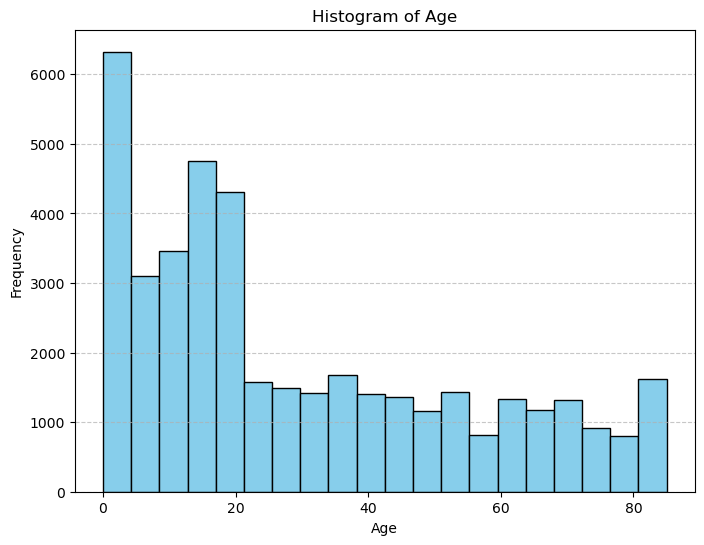

In [21]:
plt.figure(figsize=(8, 6))
plt.hist(results_df['nhanesdemographicsAGE'], bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines
plt.show()

### Plot a pie chart of the sex distribution 

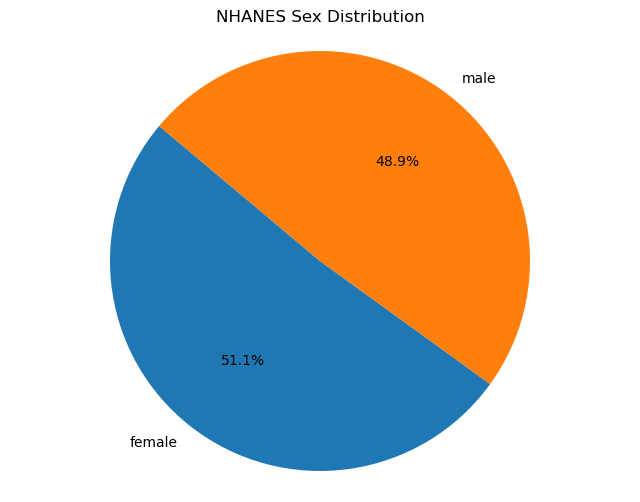

In [22]:
sex_counts = results_df['nhanesdemographicsSEX'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('NHANES Sex Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### Plot a bar chart to visualize the race distribution

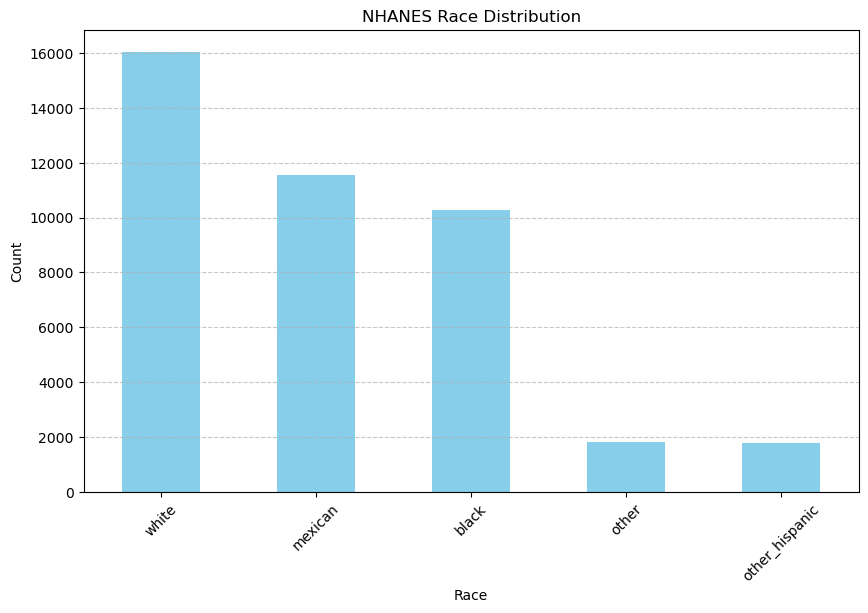

In [23]:
# Count the occurrences of each race category
race_counts = results_df['nhanesdemographicsRACE'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
race_counts.plot(kind='bar', color='skyblue')
plt.title('NHANES Race Distribution')
plt.xlabel('Race')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines
plt.show()

### Plot the distribution of cholesterol labs to compare average Total, HDL, and LDL values

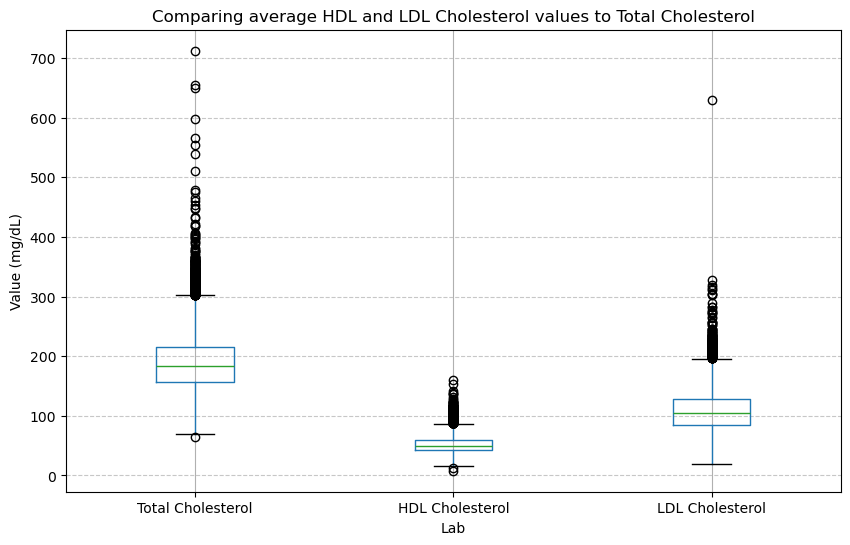

In [30]:
# Rename our column names to make them more human readable
results_df.rename(columns = {'nhaneslaboratory_biochemistryCholesterol_(mg/dL)': 'Total Cholesterol',
       'nhaneslaboratory_biochemistryHDL-cholesterol_(mg/dL)': 'HDL Cholesterol',
       'nhaneslaboratory_biochemistryLDL-cholesterol_(mg/dL)': 'LDL Cholesterol'}, inplace = True)

labs = ['Total Cholesterol', 'HDL Cholesterol', 'LDL Cholesterol']

# Plotting the box plots
plt.figure(figsize=(10, 6))
results_df[labs].boxplot()
plt.title('Comparing average HDL and LDL Cholesterol values to Total Cholesterol')
plt.ylabel('Value (mg/dL)')
plt.xlabel('Lab')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines
plt.show()